# 1. Basic imports and settings

In [1]:
import os
import sys
import argparse
sys.path.append("/mnt/8t/jjr/Structural-DPP-IV")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
# from model import StructuralDPPIV
from config import load_config
from config.load_constant import constant
from data import StructuralEncode
from data import Encode
from util import util_draw

config_dict = load_config.load_default_args_dict("StructuralDPPIV")
config_dict['max_epochs'] = 150
config_dict['gpus'] = [3]  # using which GPU to train
config_dict['batch_size'] = 32
config_dict['lr'] = 0.000005
config_dict['model'] = 'StructuralDPPIV'
config_dict['log_dir'] = constant['path_log']
config_dict['max_seq_len'] = 90
args = argparse.Namespace(**config_dict)

/mnt/8t/jjr/Structural-DPP-IV


In [4]:
class StructuralDPPIV(nn.Module):
    def __init__(self, config):
        super(StructuralDPPIV, self).__init__()
        self.StructEncodeModule = Structural(config)
        self.TextCNN = TextCNN()

        self.classification = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.Ws = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.Wh = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)

    def forward(self, x):
        TextCNN_Only = False
        StructuralEncodingOnly = False
        assert not (TextCNN_Only and StructuralEncodingOnly)
        if not TextCNN_Only and not StructuralEncodingOnly:
            TextCNNEncode = self.TextCNN(x[0])
            StructedEncode = self.StructEncodeModule(x[1])
            newEncode = TextCNNEncode * StructedEncode
            output = self.classification(newEncode)
            return output, newEncode
        elif TextCNN_Only:
            TextCNNEncode = self.TextCNN(x[0])
            output = self.classification(TextCNNEncode)
            return output, TextCNNEncode
        elif StructuralEncodingOnly:
            StructedEncode = self.StructEncodeModule(x[1])
            output = self.classification(StructedEncode)
            return output, StructedEncode


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.visualization = False
        vocab_size = 24
        dim_embedding = 100
        print(f"[INFO] using CNN config of {dataset_name}")
        # filter_sizes = [1, 2, 4, 8, 16, 24, 32, 48, 64]
        filter_sizes = [1, 2]
        filter_num = 90
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, filter_num, (fsz, dim_embedding)) for fsz in filter_sizes])
        self.linear = nn.Linear(filter_num * len(filter_sizes), 1024)

    def forward(self, x):
        # print("\nx = \n", x)
        x = self.embedding(x)
        x = x.view(x.size(0), 1, x.size(1), -1)
        x = [F.relu(conv(x)) for conv in self.convs]

        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), x_item.size(3))) for x_item in x]
        x = [x_item.view(x_item.size(0), -1) for x_item in x]
        embedding = torch.cat(x, 1)
        embedding = self.linear(embedding)

        return embedding


class Structural(nn.Module):
    def __init__(self, config):
        super(Structural, self).__init__()
        self.config = config
        self.inpuchannel = [32, 32, 64]
        global dataset_name
        dataset_name = 'DPP-IV'
        print(f"[INFO] using Structural config of {dataset_name}")
        self.embedding_dim = 21
        global max_seq_len
        max_seq_len = config.max_seq_len
        self.conv = torch.nn.Conv2d(self.embedding_dim, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        # self.conv = torch.nn.Conv2d(19, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        self.resBlock1 = resBlock(self.inpuchannel[0], self.inpuchannel[1])
        self.resBlock2 = resBlock(self.inpuchannel[1], self.inpuchannel[2], increDimen=True)
        self.linear = nn.Linear(23552, 1024)

    def forward(self, graph):
        # 90 is the max length of sequence, 15 is the number of amino acid, 21 is the number of channel
        graph = graph.cuda()  # (batchSize, 90, 15, 21)
        graph = graph.transpose(2, 3)  # (batchSize, 90, 21, 15)
        graph = graph.transpose(1, 2)   # (batchSize, 21, 90, 15)
        representation = self.conv(graph) # (batchSize, 32, 90, 15)
        representation = self.resBlock1(representation) # (batchSize, 32, 90, 15)
        representation = self.resBlock2(representation) # (batchSize, 64, 46, 8)
        representation = representation.flatten(start_dim=1) # (batchSize, 23552)
        representation = self.linear(representation) # (batchSize, 1024)
        return representation


class resBlock(nn.Module):
    def __init__(self, inputchannel, outputchannel, increDimen=False):
        super(resBlock, self).__init__()
        self.increDimen = increDimen
        self.inputchannel = inputchannel
        self.outputchannel = outputchannel
        padding_dim1 = 2 if max_seq_len % 2 == 0 else 1
        self.conv = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=(2, 2), padding=(padding_dim1, 1))
        self.conv1 = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(inputchannel, affine=True)
        self.conv2 = torch.nn.Conv2d(outputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(outputchannel, affine=True)

    def forward(self, feature):
        original = feature

        if self.increDimen:
            feature = F.max_pool2d(input=feature, kernel_size=(2, 2), padding=1)
            original = self.conv(original)
        feature = self.batchnorm1(feature)
        feature = F.relu(feature)
        feature = self.conv1(feature)
        feature = self.batchnorm2(feature)
        feature = F.relu(feature)
        feature = self.conv2(feature)
        feature = feature + original
        return feature

In [5]:
def load_params(model, param_path):
    pretrained_dict = torch.load(param_path)['state_dict']
    # print(pretrained_dict.keys())
    new_model_dict = model.state_dict()
    # print(new_model_dict.keys())
    pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in pretrained_dict.items() if '.'.join(k.split('.')[1:]) in new_model_dict}
    # pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in new_model_dict}
    print(pretrained_dict.keys())
    new_model_dict.update(pretrained_dict)
    model.load_state_dict(new_model_dict)

In [6]:
def get_one_sequence_code(sequence = 'YPFPGPIP'):
    # sequence = 'YPFPGPIP'

    sequence_data_process = Encode.codePeptides([sequence])
    sequence_data_length = len(sequence_data_process[0])
    sequence_data_padding = np.pad(sequence_data_process[0], (0, 90 - sequence_data_length), 'constant', constant_values=0)
    sequence_data = torch.tensor(np.array([sequence_data_padding])).cuda()

    Channel = StructuralEncode.convert_to_graph_channel(sequence)
    Structure_data = StructuralEncode.convert_to_graph_channel_returning_maxSeqLenx15xfn(Channel, cubeBiased=False,
                                                                 maxSeqLen=90, cubeBias=False,
                                                                 right_align=False)
    tensor_Structure_data = torch.tensor(Structure_data).cuda()
    tensor_Structure_data = torch.unsqueeze(tensor_Structure_data, 0)

    # sequence_data = sequence_data_process.cuda()
    # print(sequence_data)
    return [sequence_data, tensor_Structure_data]

In [7]:
def load_tsv(filename, skip_head=True):
    sequences = []
    labels = []
    with open(filename, 'r') as file:
        if skip_head:
            next(file)
        for line in file:
            if line[-1] == '\n':
                line = line[:-1]
            list = line.split('\t')
            sequences.append(list[2])
            labels.append(int(list[1]))
    return sequences, labels

In [8]:
new_model = StructuralDPPIV(args).cuda()
load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_3/checkpoints/epoch=73,step=2442,val_SE_epoch=0.95,val_SP_epoch=0.87,val_F1_epoch=0.91,val_AUC_epoch=1.00.ckpt')

[INFO] using Structural config of DPP-IV
[INFO] using CNN config of DPP-IV
dict_keys(['Ws', 'Wh', 'StructEncodeModule.conv.weight', 'StructEncodeModule.conv.bias', 'StructEncodeModule.resBlock1.conv.weight', 'StructEncodeModule.resBlock1.conv.bias', 'StructEncodeModule.resBlock1.conv1.weight', 'StructEncodeModule.resBlock1.conv1.bias', 'StructEncodeModule.resBlock1.batchnorm1.weight', 'StructEncodeModule.resBlock1.batchnorm1.bias', 'StructEncodeModule.resBlock1.batchnorm1.running_mean', 'StructEncodeModule.resBlock1.batchnorm1.running_var', 'StructEncodeModule.resBlock1.batchnorm1.num_batches_tracked', 'StructEncodeModule.resBlock1.conv2.weight', 'StructEncodeModule.resBlock1.conv2.bias', 'StructEncodeModule.resBlock1.batchnorm2.weight', 'StructEncodeModule.resBlock1.batchnorm2.bias', 'StructEncodeModule.resBlock1.batchnorm2.running_mean', 'StructEncodeModule.resBlock1.batchnorm2.running_var', 'StructEncodeModule.resBlock1.batchnorm2.num_batches_tracked', 'StructEncodeModule.resBlock2.

In [9]:
new_model.eval()
DATA = get_one_sequence_code('TSSEVATEVPFRLMHPQPED')
output, embedding = new_model(DATA)

In [10]:
pred_prob = []
label_pred = []
predict_true = 0

sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
# sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/train/train.tsv')
from tqdm import tqdm
# predict sequence one by one
for index in tqdm(range(len(sequences))):
    # print("before success2:", config.learn_name)
    sequence_code = get_one_sequence_code(sequences[index])
    logits, representation = new_model(sequence_code)

    pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
    pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
    pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
    pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

    pred_prob = pred_prob + pred_prob_positive.tolist()
    label_pred = label_pred + pred_class.tolist()

acc = accuracy_score(labels, label_pred)
auc = roc_auc_score(labels, pred_prob)
f1 = f1_score(labels, label_pred)
se = recall_score(labels, label_pred)
sp = recall_score(labels, label_pred, pos_label=0)

print('acc:', acc)
print('auc:', auc)
print('f1:', f1)
print('se:', se)
print('sp:', sp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:03<00:00, 82.21it/s]

acc: 0.9097744360902256
auc: 0.9657414212222284
f1: 0.9130434782608695
se: 0.9473684210526315
sp: 0.8721804511278195


# 2. PyTorch-Grad-CAM DEMO

In [38]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.nn.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


image_url = "https://farm1.staticflickr.com/6/9606553_ccc7518589_z.jpg"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(type(output), output.keys())

<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


In [66]:
image.shape

(375, 500, 3)

In [67]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)["out"]

model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)
print(output)

tensor([[[[10.5353, 10.5353, 10.5353,  ...,  9.2733,  9.2733,  9.2733],
          [10.5353, 10.5353, 10.5353,  ...,  9.2733,  9.2733,  9.2733],
          [10.5353, 10.5353, 10.5353,  ...,  9.2733,  9.2733,  9.2733],
          ...,
          [ 8.6696,  8.6696,  8.6696,  ...,  9.0761,  9.0761,  9.0761],
          [ 8.6696,  8.6696,  8.6696,  ...,  9.0761,  9.0761,  9.0761],
          [ 8.6696,  8.6696,  8.6696,  ...,  9.0761,  9.0761,  9.0761]],

         [[-1.2029, -1.2029, -1.2029,  ..., -1.4451, -1.4451, -1.4451],
          [-1.2029, -1.2029, -1.2029,  ..., -1.4451, -1.4451, -1.4451],
          [-1.2029, -1.2029, -1.2029,  ..., -1.4451, -1.4451, -1.4451],
          ...,
          [ 0.0774,  0.0774,  0.0774,  ..., -1.2555, -1.2555, -1.2555],
          [ 0.0774,  0.0774,  0.0774,  ..., -1.2555, -1.2555, -1.2555],
          [ 0.0774,  0.0774,  0.0774,  ..., -1.2555, -1.2555, -1.2555]],

         [[-2.3725, -2.3725, -2.3725,  ..., -1.4499, -1.4499, -1.4499],
          [-2.3725, -2.3725, -

In [68]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
print(normalized_masks.shape)
print(sem_class_to_idx)


torch.Size([1, 21, 375, 500])
{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


7
(375, 500)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(375, 500)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


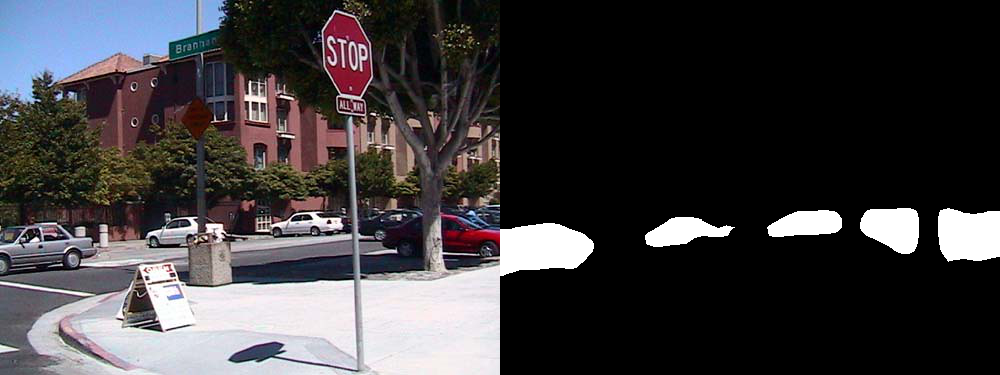

In [69]:
car_category = sem_class_to_idx["car"]
print(car_category)
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
print(car_mask.shape)
print(car_mask)
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
print(car_mask_uint8.shape)
print(car_mask_uint8)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

In [92]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


target_layers = [model.model.backbone.layer4]
print(target_layers)
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
print(output.shape)
print(car_mask_float.shape)
print(targets[0](output.squeeze(0)))

[Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

IndexError: too many indices for tensor of dimension 1

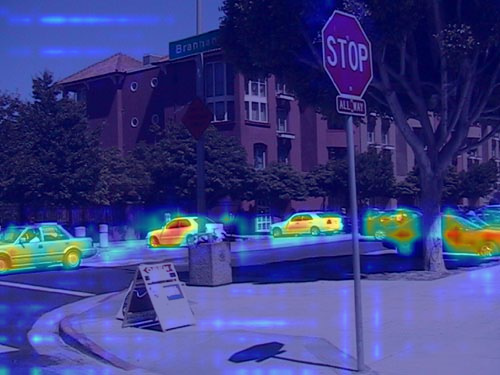

In [93]:
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)

In [99]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
targets = [ClassifierOutputTarget(281)]

In [100]:
print(target_layers)
print(targets)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


# 3.0 DIY BASECAM

In [48]:
import numpy as np
import torch
import ttach as tta
from typing import Callable, List, Tuple
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:
        # print(grads)
        # print(grads.shape)
        # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # if self.cuda:
        #     input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(
                category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            # loss_array = torch.tensor([target(output) for target, output in zip(targets, outputs)])
            # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            # print(loss_array)
            # loss = sum(loss_array)
            # loss = loss_array.sum(axis = 0)
            # loss = torch.tensor([target(output) for target, output in zip(targets, outputs)])
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        width, height = input_tensor[1].size(-1), input_tensor[1].size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]
            # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            # print(layer_grads)
            # print(layer_grads.shape)
            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            cam = np.maximum(cam, 0)
            # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            scaled = scale_cam_image(cam, target_size)
            # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

# 3.1 DIY ClassificationTarget

In [49]:
class ClassificationTarget:
    def __init__(self,target_category):
        self.target_category = target_category

    def __call__(self, model_output):
        # print(model_output.shape)
        # print(model_output)
        pred_prob_all = F.softmax(model_output, dim=1)
        # print(pred_prob_all.shape)
        # print(pred_prob_all)
        loss = (pred_prob_all[:, self.target_category])
        # print(loss)
        return loss

In [50]:
# Test ClassificationTarget
target_layers = [new_model.StructEncodeModule.resBlock2.conv2]
Targets = [ClassificationTarget(1)]
print(target_layers)
DATA = get_one_sequence_code('IPI')
output, embedding = new_model(DATA)
Targets[0](output)
# Targets[0](torch.tensor([[0.1,0.9],[0.1,0.8]]))

[Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)]


tensor([0.9640], device='cuda:0', grad_fn=<SelectBackward0>)

In [51]:
DATA = get_one_sequence_code('IPI')

# 3.2.1 GradCAM

In [52]:
class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        # print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        # print(grads)
        # print(grads.shape)
        return np.mean(grads, axis=(2, 3))

In [53]:
# DATA = get_one_sequence_code(sequences[0])
with GradCAM(model=new_model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=DATA,
                        targets=Targets)

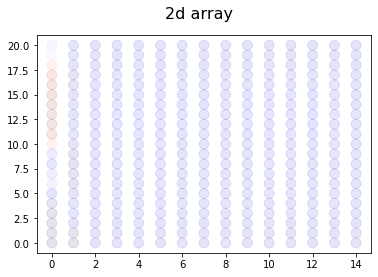

In [54]:
# grayscale_cam[0].shape
util_draw.plot_2d_array(grayscale_cam[0])

## 3.2.2 GradCAM++

In [55]:
class GradCAMPlusPlus(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(GradCAMPlusPlus, self).__init__(model, target_layers, use_cuda,
                                              reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layers,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads**2
        grads_power_3 = grads_power_2 * grads
        # Equation 19 in https://arxiv.org/abs/1710.11063
        sum_activations = np.sum(activations, axis=(2, 3))
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 +
                               sum_activations[:, :, None, None] * grads_power_3 + eps)
        # Now bring back the ReLU from eq.7 in the paper,
        # And zero out aijs where the activations are 0
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights, axis=(2, 3))
        # print(weights.shape)
        # print(weights)
        return weights


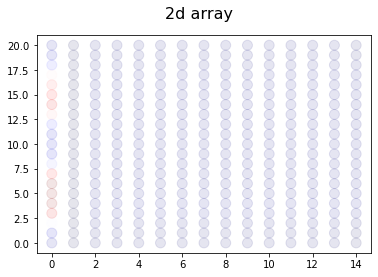

In [56]:
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM
with GradCAMPlusPlus(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:

    grayscale_cam = cam(input_tensor=DATA,
                        targets=Targets)
util_draw.plot_2d_array(grayscale_cam[0])

In [57]:
from tqdm import tqdm
class ScoreCAM(BaseCAM):
    def __init__(
            self,
            model,
            target_layers,
            use_cuda=False,
            reshape_transform=None):
        super(ScoreCAM, self).__init__(model,
                                       target_layers,
                                       use_cuda,
                                       reshape_transform=reshape_transform,
                                       uses_gradients=False)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        targets,
                        activations,
                        grads):
        with torch.no_grad():
            # print(input_tensor[0].shape)
            # print(input_tensor[1].shape)
            input_tensor_seq = input_tensor[0]
            # input_tensor = input_tensor[1]
            upsample = torch.nn.UpsamplingBilinear2d(
                size=input_tensor[1].shape[-2:])
            activation_tensor = torch.from_numpy(activations)
            if self.cuda:
                activation_tensor = activation_tensor.cuda()

            upsampled = upsample(activation_tensor)

            maxs = upsampled.view(upsampled.size(0),
                                  upsampled.size(1), -1).max(dim=-1)[0]
            mins = upsampled.view(upsampled.size(0),
                                  upsampled.size(1), -1).min(dim=-1)[0]

            maxs, mins = maxs[:, :, None, None], mins[:, :, None, None]
            upsampled = (upsampled - mins) / (maxs - mins)

            # print(input_tensor[1][:, None, :, :].shape)
            # print(upsampled[:, :, None, :, :].shape)
            input_tensors = input_tensor[1][:, None,
                                         :, :] * upsampled[:, :, None, :, :]
            # print(input_tensors.shape)
            # print(input_tensors)
            # input_tensors = [input_tensor_seq, input_tensors]
            if hasattr(self, "batch_size"):
                BATCH_SIZE = self.batch_size
            else:
                BATCH_SIZE = 4

            scores = []
            # print(targets)
            for target, tensor in zip(targets, input_tensors):
                # print(tensor.shape)
                for i in tqdm(range(0, tensor.size(0), BATCH_SIZE)):
                    batch_structural = tensor[i: i + BATCH_SIZE, :]
                    # copy input_tensor_seq sixteen times
                    batch_seq = input_tensor_seq.repeat(BATCH_SIZE, 1 )
                    batch_input = [input_tensor_seq, batch_structural]
                    # print("xxxxxxxxxxxxxxxxxxxxxx")

                    # print(output.shape)
                    # print(output)
                    # for o in output:
                    #     o = torch.unsqueeze(o,dim=0)
                    #     print(o)

                    outputs = [target(torch.unsqueeze(o,dim=0)).cpu().item()
                               for o in self.model(batch_input)[0]]
                    # print(outputs)
                    scores.extend(outputs)

            scores = torch.Tensor(scores)
            # print("xxxxxxxxxxxxxxxxxxxxxx")
            # print(scores.shape)
            # print(activations.shape)
            scores = scores.view(activations.shape[0], activations.shape[1])
            # print("xxxxxxxxxxxxxxxxxxxxxx")
            weights = torch.nn.Softmax(dim=-1)(scores).numpy()
            # print("xxxxxxxxxxxxxxxxxxxxxx")
            return weights

In [58]:
with ScoreCAM(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:

    grayscale_cam = cam(input_tensor=DATA,
                        targets=Targets)

# print(grayscale_cam.shape)
# print(grayscale_cam)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 359.10it/s]


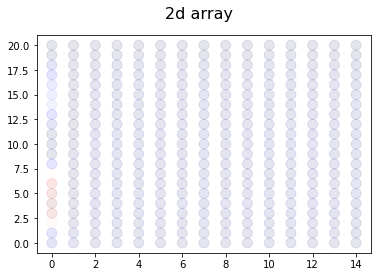

In [59]:
util_draw.plot_2d_array(grayscale_cam[0])

In [60]:
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
# https://ieeexplore.ieee.org/document/9462463

class LayerCAM(BaseCAM):
    def __init__(
            self,
            model,
            target_layers,
            use_cuda=False,
            reshape_transform=None):
        super(
            LayerCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        spatial_weighted_activations = np.maximum(grads, 0) * activations

        if eigen_smooth:
            cam = get_2d_projection(spatial_weighted_activations)
        else:
            cam = spatial_weighted_activations.sum(axis=1)
        return cam

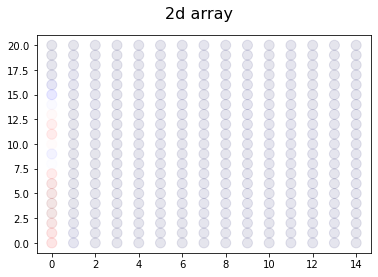

In [61]:

with LayerCAM(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:

    grayscale_cam = cam(input_tensor=DATA,
                        targets=Targets)
util_draw.plot_2d_array(grayscale_cam[0])

In [62]:
import numpy as np
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection


class HiResCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            HiResCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        elementwise_activations = grads * activations
        # print(elementwise_activations)
        if eigen_smooth:
            print(
                "Warning: HiResCAM's faithfulness guarantees do not hold if smoothing is applied")
            cam = get_2d_projection(elementwise_activations)
        else:
            cam = elementwise_activations.sum(axis=1)
        return cam

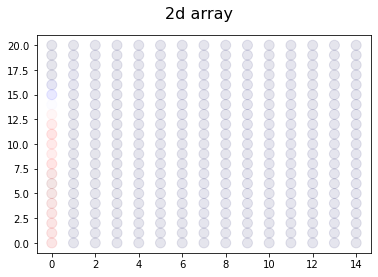

In [63]:
with HiResCAM(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:

    grayscale_cam = cam(input_tensor=DATA,
                        targets=Targets)
util_draw.plot_2d_array(grayscale_cam[0])

In [64]:
import numpy as np
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection


class GradCAMElementWise(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAMElementWise,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        elementwise_activations = np.maximum(grads * activations, 0)

        if eigen_smooth:
            cam = get_2d_projection(elementwise_activations)
        else:
            cam = elementwise_activations.sum(axis=1)
        return cam

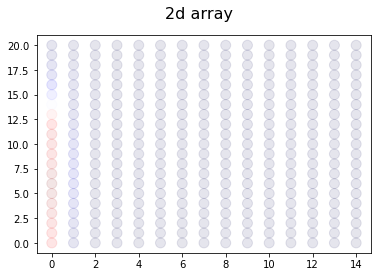

In [65]:
with GradCAMElementWise(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:

    grayscale_cam = cam(input_tensor=DATA,
                        targets=Targets)
util_draw.plot_2d_array(grayscale_cam[0])

In [66]:
class XGradCAM(BaseCAM):
    def __init__(
            self,
            model,
            target_layers,
            use_cuda=False,
            reshape_transform=None):
        super(
            XGradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        sum_activations = np.sum(activations, axis=(2, 3))
        eps = 1e-7
        weights = grads * activations / \
            (sum_activations[:, :, None, None] + eps)
        weights = weights.sum(axis=(2, 3))
        return weights

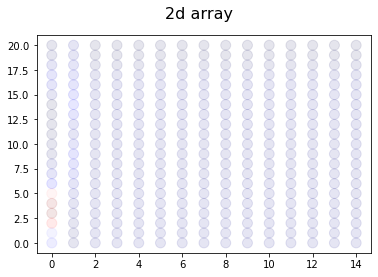

In [67]:
with XGradCAM(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:

    grayscale_cam = cam(input_tensor=DATA,
                        targets=Targets)
util_draw.plot_2d_array(grayscale_cam[0])

# 4. analysis

In [68]:
from matplotlib import pyplot as plt
def plot_bar(Xdata, Ydata, title):
    fig = plt.figure()
    plt.bar(Xdata, Ydata)
    plt.title(title)
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    plt.show()

In [77]:
def feature_analysis(sequences):
    feature_scores = [0 for i in range(21)]
    # if cam_type == 'GradCAM':
    #     CAM = GradCAM
    for sequence in sequences:
        # print(sequence)
        DATA = get_one_sequence_code(sequence)
        with ScoreCAM(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:
            grayscale_cam = cam(input_tensor=DATA,
                                targets=Targets)

        feature_sequence_sum = grayscale_cam[0].sum(axis=0).tolist()
        for i in range(len(feature_scores)):
            feature_scores[i] = feature_scores[i] + feature_sequence_sum[i]

    plot_bar([i for i in range(21)], feature_scores, 'ScoreCAM')

    return feature_scores

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 457.48it/s]


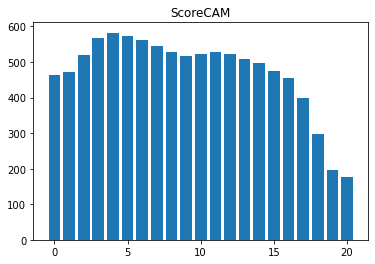

In [78]:
feature_scores = feature_analysis(sequences)

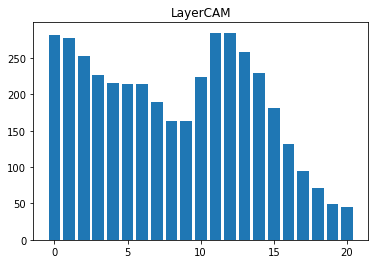

In [76]:
feature_scores = feature_analysis(sequences)

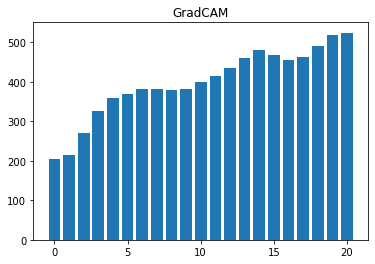

In [72]:
feature_scores = feature_analysis(sequences)

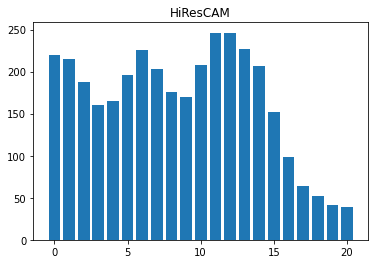

In [74]:
feature_scores = feature_analysis(sequences)

In [43]:
feature_scores

[203.53974289167672,
 214.07479787733064,
 270.26173331040627,
 326.44866959389765,
 357.7717491443036,
 369.75626387956436,
 381.74077159125045,
 380.84726176434197,
 379.09521671640687,
 382.788546907017,
 398.461697507184,
 414.1348481683526,
 435.5023558565881,
 459.45819006161764,
 481.12646000282257,
 468.48106317967176,
 455.83568019699305,
 461.25752848386765,
 489.9086965918541,
 518.5598611235619,
 523.9319556057453]

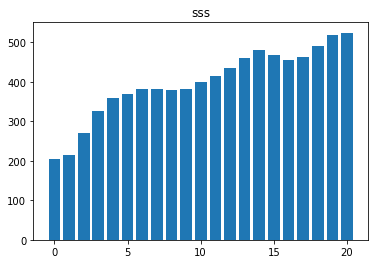

In [47]:
plot_bar([i for i in range(21)], feature_scores, 'sss')